## Setup

In [1]:
# Packages
import pandas as pd
import torch
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
%matplotlib inline
import pylab
import math

In [2]:
# Import data
tor_df = pd.read_csv("/home/jeremy/github_tornadoesr/data/raw/tor_train_set.csv")


# Quick inspection
tor_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11959 entries, 0 to 11958
Data columns (total 35 columns):
DAMAGE_PROPERTY       11959 non-null float64
DURATION_SECONDS      11959 non-null float64
BEGIN_LAT             11959 non-null float64
BEGIN_LON             11959 non-null float64
TOR_LENGTH            11959 non-null float64
TOR_WIDTH             11959 non-null float64
YEAR                  11959 non-null float64
MULTI_VORT_IND        11959 non-null int64
OPEN_WATER_PROP       11959 non-null float64
DEV_OPEN_PROP         11959 non-null float64
DEV_LOW_PROP          11959 non-null float64
DEV_MED_PROP          11959 non-null float64
DEV_HIGH_PROP         11959 non-null float64
BARREN_LAND_PROP      11959 non-null float64
DECID_FOREST_PROP     11959 non-null float64
EVERGR_FOREST_PROP    11959 non-null float64
MIXED_FOREST_PROP     11959 non-null float64
SHRUB_SCRUB_PROP      11959 non-null float64
GRASS_LAND_PROP       11959 non-null float64
PASTURE_HAY_PROP      11959 non-null f

In [3]:
# Seperating variables
# The dependent variables
tornado_outcomes = tor_df.iloc[:, [0]]


# Quick inspection
tornado_outcomes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11959 entries, 0 to 11958
Data columns (total 1 columns):
DAMAGE_PROPERTY    11959 non-null float64
dtypes: float64(1)
memory usage: 93.5 KB


In [4]:
# The independent variables
tornado_features = tor_df.loc[:, ["DURATION_SECONDS",
                                  "TOR_LENGTH",
                                  "TOR_WIDTH",
                                  "YEAR",
                                  "MULTI_VORT_IND",
                                  "TOR_AREA",
                                  "DAY_OF_YEAR",
                                  "MONTH",
                                  "TIME"]]


# Quick inspection
tornado_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11959 entries, 0 to 11958
Data columns (total 9 columns):
DURATION_SECONDS    11959 non-null float64
TOR_LENGTH          11959 non-null float64
TOR_WIDTH           11959 non-null float64
YEAR                11959 non-null float64
MULTI_VORT_IND      11959 non-null int64
TOR_AREA            11959 non-null float64
DAY_OF_YEAR         11959 non-null float64
MONTH               11959 non-null float64
TIME                11959 non-null float64
dtypes: float64(8), int64(1)
memory usage: 840.9 KB


In [5]:
# Make the dependent variables into a numpy array
outcomes_array = tornado_outcomes.values


# Makes the numpy array into a torch Tensor
outcomes_Tensor = torch.from_numpy(outcomes_array)


# Quick inspection
outcomes_Tensor


 0.1532
 0.6540
 0.0873
   ⋮    
-1.4219
 0.1532
 0.2814
[torch.DoubleTensor of size 11959x1]

In [6]:
# Make the independent variables into a numpy array
features_array = tornado_features.values


# Make the numpy array into a torch Tensor
features_Tensor = torch.from_numpy(features_array)


# Quick inspection
features_Tensor


 0.0227 -0.4127 -0.7859  ...  -0.0068 -0.2947 -0.4531
-0.3046 -1.0358 -0.9368  ...  -0.1143 -0.2947  1.1092
 0.3520  0.0818 -0.9368  ...  -0.9653 -1.0297 -0.1038
          ...             ⋱             ...          
-2.2692 -1.1419 -1.6746  ...   0.2394  0.0728 -0.5450
 0.0227 -0.4127 -0.7859  ...   0.8091  0.8078 -2.1918
 0.4583  0.9771 -0.3589  ...  -2.1091 -1.7647  0.5064
[torch.DoubleTensor of size 11959x9]

### Convert DoubleTensor to FloatTensor

In [7]:
# Changing dependent variables from a DoubleTensor to a FloatTensor
outcomes_Tensor = outcomes_Tensor.float()


# ...and for the independent variables
features_Tensor = features_Tensor.float()


# Quick check
features_Tensor


 0.0227 -0.4127 -0.7859  ...  -0.0068 -0.2947 -0.4531
-0.3046 -1.0358 -0.9368  ...  -0.1143 -0.2947  1.1092
 0.3520  0.0818 -0.9368  ...  -0.9653 -1.0297 -0.1038
          ...             ⋱             ...          
-2.2692 -1.1419 -1.6746  ...   0.2394  0.0728 -0.5450
 0.0227 -0.4127 -0.7859  ...   0.8091  0.8078 -2.1918
 0.4583  0.9771 -0.3589  ...  -2.1091 -1.7647  0.5064
[torch.FloatTensor of size 11959x9]

## Round 1: One-Hidden-Layer Neural Network

In [8]:
# Make the torch Tensor into a PyTorch Variable for dependent variables
outcomes_Variable = Variable(outcomes_Tensor)


# ...for independent variables
features_Variable = Variable(features_Tensor,
                             requires_grad = False)

In [9]:
# Make the neural network
model = torch.nn.Sequential(torch.nn.Linear(9, 6),
                            torch.nn.ReLU(),
                            torch.nn.Linear(6, 1))

In [10]:
# Set the loss function
loss_fn = torch.nn.MSELoss(size_average=False)

In [11]:
# To add errors to
errors = []


# Set the learning rate
learning_rate = 1e-2


# Define the model's optimizer
optimizer = torch.optim.Adagrad(model.parameters(), lr = learning_rate)


# Train the neural network
for t in range(15000):
    
    # Get the current predictions
    y_pred = model(features_Variable)
    
    # Compute and append current summed errors
    loss = loss_fn(y_pred, outcomes_Variable)
    errors.append(loss.data[0])
    
    # Zero the gradients before running the backward pass.
    optimizer.zero_grad()
    
    # Backward pass: compute gradient of the loss with respect to all the learnable Variables
    loss.backward()
    
    # Update the weights using Adagrad
    optimizer.step()

In [12]:
# Get the iterations
iterations = list(range(0, 15000))

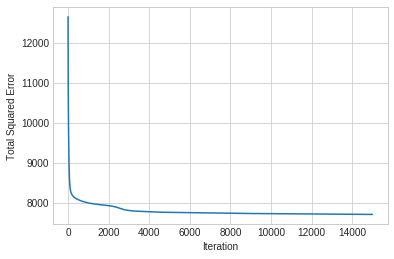

In [13]:
# Plot summed error as a function of iteration
plt.plot(iterations, errors)

plt.xlabel("Iteration")

plt.ylabel("Total Squared Error")

In [14]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_pred_resized = y_pred.resize(11959)


# Make the FloatTensor into a numpy.array
y_pred_array = y_pred_resized.data.numpy()


# Make the numpy.array into a list
y_pred_list = y_pred_array.tolist()


# This is for the validation performance plot later
y_pred_array_for_perf = y_pred_resized.data.numpy()*5.407597 + 7.688844

y_pred_list_for_perf = y_pred_array_for_perf.tolist()

In [15]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
outcomes_Variable_resized = outcomes_Variable.resize(11959)


# Make the FloatTensor into a numpy.array
outcomes_array = outcomes_Variable_resized.data.numpy()


# Make the numpy.array into a list
outcomes_list = outcomes_array.tolist()


# This is for the validation performance plot later
outcomes_array_for_perf = outcomes_Variable_resized.data.numpy()*5.407597 + 7.688844

outcomes_list_for_perf = outcomes_array_for_perf.tolist()

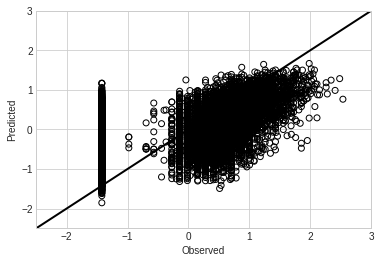

In [16]:
# Plot predictions versus training set outcomes
plt.scatter(outcomes_list, y_pred_list, facecolors = "none", edgecolors = "k")

axes = plt.gca()

axes.set_xlim([-2.5, 3])

axes.set_ylim([-2.5, 3])

plt.plot([-2.5, 3], [-2.5, 3], 'k-', lw = 2)

plt.xlabel("Observed")

plt.ylabel("Predicted")

### Round 1.1: Validation Set Performance

In [17]:
# Import data
valid_df = pd.read_csv("/home/jeremy/github_tornadoesr/data/raw/tor_cv_set.csv")


# Validation set outcomes
valid_outcomes = valid_df.iloc[:, [0]]


# Make the validation outcomes into a numpy array
valid_outcomes_array = valid_outcomes.values


# Makes the numpy array into a torch Tensor
valid_outcomes_Tensor = torch.from_numpy(valid_outcomes_array)


# Changing validation outcomes from a DoubleTensor to a FloatTensor
valid_outcomes_Tensor = valid_outcomes_Tensor.float()


# Make the Tensor into a Pytorch Variable
valid_outcomes_Variable = Variable(valid_outcomes_Tensor)


# Quick check
valid_outcomes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3987 entries, 0 to 3986
Data columns (total 1 columns):
DAMAGE_PROPERTY    3987 non-null float64
dtypes: float64(1)
memory usage: 31.2 KB


In [18]:
# Validation set predictors
valid_predictors = valid_df.loc[:, ["DURATION_SECONDS",
                                    "TOR_LENGTH",
                                    "TOR_WIDTH",
                                    "YEAR",
                                    "MULTI_VORT_IND",
                                    "TOR_AREA",
                                    "DAY_OF_YEAR",
                                    "MONTH",
                                   "TIME"]]


# Make the validation predictors into a numpy array
valid_predictors_array = valid_predictors.values


# Makes the numpy array into a torch Tensor
valid_predictors_Tensor = torch.from_numpy(valid_predictors_array)


# Changing validation predictors from a DoubleTensor to a FloatTensor
valid_predictors_Tensor = valid_predictors_Tensor.float()


# Make the Tensor into a Pytorch Variable
valid_predictors_Variable = Variable(valid_predictors_Tensor)


# Quick check
valid_predictors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3987 entries, 0 to 3986
Data columns (total 9 columns):
DURATION_SECONDS    3987 non-null float64
TOR_LENGTH          3987 non-null float64
TOR_WIDTH           3987 non-null float64
YEAR                3987 non-null float64
MULTI_VORT_IND      3987 non-null int64
TOR_AREA            3987 non-null float64
DAY_OF_YEAR         3987 non-null float64
MONTH               3987 non-null float64
TIME                3987 non-null float64
dtypes: float64(8), int64(1)
memory usage: 280.4 KB


In [19]:
# Get the validation set predictions
y_valid_pred = model(valid_predictors_Variable)


# Get the loss - (total) residual sum of squares
total_SE = loss_fn(y_valid_pred, valid_outcomes_Variable)


# Average that to get mean square error
mean_SE = total_SE / len(y_valid_pred)

mean_SE

Variable containing:
 0.6697
[torch.FloatTensor of size 1]

In [20]:
# Computing the total sum of squares
# Get a torch Variable of the mean outcome
# Compute mean value
valid_outcomes_mean = (sum(valid_outcomes_Variable) / len(valid_outcomes_Variable))
valid_outcomes_mean = valid_outcomes_mean.data.numpy()[0]

# Make that into a ndarray
valid_outcomes_mean = np.repeat(valid_outcomes_mean, len(valid_outcomes_Variable))

# Turn the array into a torch Tensor
valid_outcomes_mean = torch.from_numpy(valid_outcomes_mean)

# Turn that Tensor into a Variable
valid_outcomes_mean_Variable = Variable(valid_outcomes_mean)

# Compute the TSS
tot_sum_squares = loss_fn(valid_outcomes_mean_Variable, valid_outcomes_Variable)


# Grab the residual sum of squares
resid_sum_squares = loss_fn(y_valid_pred, valid_outcomes_Variable)


# Compute R squared
R_squared = 1 - (resid_sum_squares / tot_sum_squares)

R_squared

Variable containing:
 0.3214
[torch.FloatTensor of size 1]

In [21]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_valid_pred_resized = y_valid_pred.resize(3987)


# Make the FloatTensor into a numpy.array
y_valid_pred_array = y_valid_pred_resized.data.numpy()


# Convert back to log scale
y_valid_pred_array = y_valid_pred_array*5.407597 + 7.688844


# Make the numpy.array into a list
y_valid_pred_list = y_valid_pred_array.tolist()

In [22]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
valid_outcomes_Variable_resized = valid_outcomes_Variable.resize(3987)


# Make the FloatTensor into a numpy.array
valid_outcomes_array = valid_outcomes_Variable_resized.data.numpy()


# Convert back to log scale
valid_outcomes_array = valid_outcomes_array*5.407597 + 7.688844


# Make the numpy.array into a list
valid_outcomes_list = valid_outcomes_array.tolist()

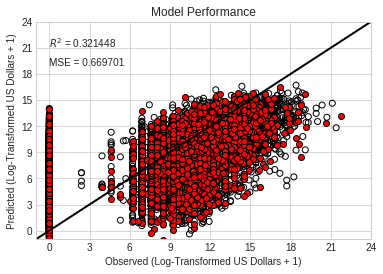

In [23]:
# Plot new predictions versus new data outcomes
plt.scatter(outcomes_list_for_perf, y_pred_list_for_perf, facecolors = "none",
            edgecolors = "k")

plt.scatter(valid_outcomes_list, y_valid_pred_list, facecolors = "r",
            edgecolors = "k")

axes = plt.gca()

axes.set_xlim([-1, 24])

axes.set_ylim([-1, 24])

axes.set_xticks([0, 3, 6, 9, 12, 15, 18, 21, 24])

axes.set_yticks([0, 3, 6, 9, 12, 15, 18, 21, 24])

plt.plot([-1, 24], [-1, 24], 'k-', lw = 2)

axes.set_xlabel("Observed (Log-Transformed US Dollars + 1)")

axes.set_ylabel("Predicted (Log-Transformed US Dollars + 1)")

axes.set_title("Model Performance")

plt.text(0, 21, r"$R^2$ = %s"%(R_squared.data.numpy()[0]))

plt.text(0, 19, "MSE = %s"%(mean_SE.data.numpy()[0]))

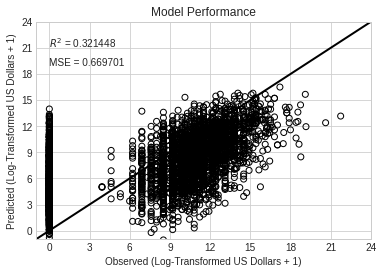

In [24]:
# Plot new predictions versus new data outcomes
plt.scatter(valid_outcomes_list, y_valid_pred_list, facecolors = "none",
            edgecolors = "k")

axes = plt.gca()

axes.set_xlim([-1, 24])

axes.set_ylim([-1, 24])

axes.set_xticks([0, 3, 6, 9, 12, 15, 18, 21, 24])

axes.set_yticks([0, 3, 6, 9, 12, 15, 18, 21, 24])

plt.plot([-1, 24], [-1, 24], 'k-', lw = 2)

axes.set_xlabel("Observed (Log-Transformed US Dollars + 1)")

axes.set_ylabel("Predicted (Log-Transformed US Dollars + 1)")

axes.set_title("Model Performance")

plt.text(0, 21, r"$R^2$ = %s"%(R_squared.data.numpy()[0]))

plt.text(0, 19, "MSE = %s"%(mean_SE.data.numpy()[0]))

In [25]:
model[(0)].weight

Parameter containing:
-0.0274 -0.0562 -0.1979  0.3227 -0.0089  0.1969  0.8643 -0.5177  0.0103
-0.1659  0.1168  0.5795 -0.2592  0.8223  0.3487 -0.1354  0.1875 -0.6264
 0.1290  0.2901  0.8942 -0.2000  1.1233 -0.4685  0.1312  0.1321  0.8161
 0.1224 -0.4193 -0.1071 -0.0056  1.0714  0.0061  0.0235  0.0119 -0.0352
-0.1391 -0.5052  0.1826  0.0223  1.0501 -0.2134  0.3680 -0.3019  0.0632
 0.0677 -0.5291  0.5514 -0.1481  0.6472  0.7457 -0.0088  0.2163  0.2347
[torch.FloatTensor of size 6x9]

## Round 2: Two-Hidden-Layer Neural Network

In [26]:
# Make the torch Tensor into a PyTorch Variable for dependent variables
outcomes_Variable = Variable(outcomes_Tensor)


# ...for independent variables
features_Variable = Variable(features_Tensor,
                             requires_grad = False)

In [27]:
# Make the neural network
model = torch.nn.Sequential(torch.nn.Linear(9, 6),
                            torch.nn.ReLU(),
                            torch.nn.Linear(6, 4),
                            torch.nn.ReLU(),
                            torch.nn.Linear(4, 1))

In [28]:
# To add errors to
errors = []


# Set the learning rate
learning_rate = 1e-2


# Define the model's optimizer
optimizer = torch.optim.Adagrad(model.parameters(), lr = learning_rate)


# Train the neural network
for t in range(15000):
    
    # Get the current predictions
    y_pred = model(features_Variable)
    
    # Compute and append current summed errors
    loss = loss_fn(y_pred, outcomes_Variable)
    errors.append(loss.data[0])
    
    # Zero the gradients before running the backward pass.
    optimizer.zero_grad()
    
    # Backward pass: compute gradient of the loss with respect to all the learnable Variables
    loss.backward()
    
    # Update the weights using Adagrad
    optimizer.step()

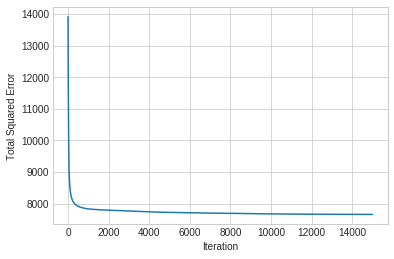

In [29]:
# Plot summed error as a function of iteration
plt.plot(iterations, errors)

plt.xlabel("Iteration")

plt.ylabel("Total Squared Error")

In [30]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_pred_resized = y_pred.resize(11959)


# Make the FloatTensor into a numpy.array
y_pred_array = y_pred_resized.data.numpy()


# Make the numpy.array into a list
y_pred_list = y_pred_array.tolist()


# This is for the validation performance plot later
y_pred_array_for_perf = y_pred_resized.data.numpy()*5.407597 + 7.688844

y_pred_list_for_perf = y_pred_array_for_perf.tolist()

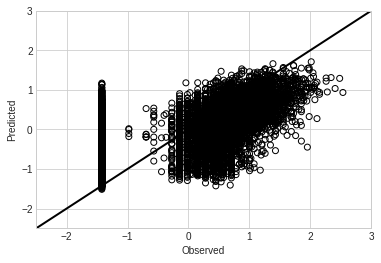

In [31]:
# Plot predictions versus training set outcomes
plt.scatter(outcomes_list, y_pred_list, facecolors = "none", edgecolors = "k")

axes = plt.gca()

axes.set_xlim([-2.5, 3])

axes.set_ylim([-2.5, 3])

plt.plot([-2.5, 3], [-2.5, 3], 'k-', lw = 2)

plt.xlabel("Observed")

plt.ylabel("Predicted")

### Round 2.1: Validation Set Performance

In [32]:
# Get the validation set predictions
y_valid_pred = model(valid_predictors_Variable)


# Get the loss - (total) residual sum of squares
total_SE = loss_fn(y_valid_pred, valid_outcomes_Variable)


# Average that to get mean square error
mean_SE = total_SE / len(y_valid_pred)

mean_SE

Variable containing:
 0.6645
[torch.FloatTensor of size 1]

In [33]:
# Grab the residual sum of squares
resid_sum_squares = loss_fn(y_valid_pred, valid_outcomes_Variable)


# Compute R squared
R_squared = 1 - (resid_sum_squares / tot_sum_squares)

R_squared

Variable containing:
 0.3267
[torch.FloatTensor of size 1]

In [34]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_valid_pred_resized = y_valid_pred.resize(3987)


# Make the FloatTensor into a numpy.array
y_valid_pred_array = y_valid_pred_resized.data.numpy()


# Convert back to log scale
y_valid_pred_array = y_valid_pred_array*5.407597 + 7.688844


# Make the numpy.array into a list
y_valid_pred_list = y_valid_pred_array.tolist()

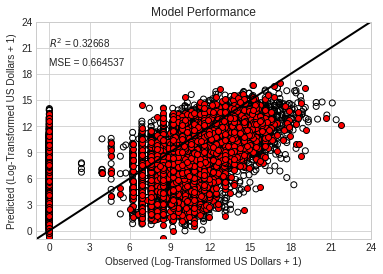

In [35]:
# Plot new predictions versus new data outcomes
plt.scatter(outcomes_list_for_perf, y_pred_list_for_perf, facecolors = "none",
            edgecolors = "k")

plt.scatter(valid_outcomes_list, y_valid_pred_list, facecolors = "r",
            edgecolors = "k")

axes = plt.gca()

axes.set_xlim([-1, 24])

axes.set_ylim([-1, 24])

axes.set_xticks([0, 3, 6, 9, 12, 15, 18, 21, 24])

axes.set_yticks([0, 3, 6, 9, 12, 15, 18, 21, 24])

plt.plot([-1, 24], [-1, 24], 'k-', lw = 2)

axes.set_xlabel("Observed (Log-Transformed US Dollars + 1)")

axes.set_ylabel("Predicted (Log-Transformed US Dollars + 1)")

axes.set_title("Model Performance")

plt.text(0, 21, r"$R^2$ = %s"%(R_squared.data.numpy()[0]))

plt.text(0, 19, "MSE = %s"%(mean_SE.data.numpy()[0]))

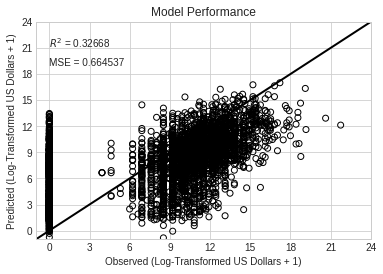

In [36]:
# Plot new predictions versus new data outcomes
plt.scatter(valid_outcomes_list, y_valid_pred_list, facecolors = "none",
            edgecolors = "k")

axes = plt.gca()

axes.set_xlim([-1, 24])

axes.set_ylim([-1, 24])

axes.set_xticks([0, 3, 6, 9, 12, 15, 18, 21, 24])

axes.set_yticks([0, 3, 6, 9, 12, 15, 18, 21, 24])

plt.plot([-1, 24], [-1, 24], 'k-', lw = 2)

axes.set_xlabel("Observed (Log-Transformed US Dollars + 1)")

axes.set_ylabel("Predicted (Log-Transformed US Dollars + 1)")

axes.set_title("Model Performance")

plt.text(0, 21, r"$R^2$ = %s"%(R_squared.data.numpy()[0]))

plt.text(0, 19, "MSE = %s"%(mean_SE.data.numpy()[0]))

In [37]:
model[(0)].weight

Parameter containing:
-0.0472  0.1504 -0.2027 -0.1640  0.7866  0.0832  0.0941 -0.4072  0.2266
 0.0904 -0.4687  0.2827 -0.1873 -1.1494  0.5782 -0.2355 -0.3674 -0.2174
 0.1041  0.0762  0.3128 -0.4338 -0.4095  0.4961  0.0832 -0.0436  0.5134
-0.2486 -0.1089 -0.1048  0.0516  1.3252  0.1801  0.5324 -0.0872 -0.2807
-0.2147  0.2522  0.0115 -0.1331  0.6567  0.3234 -0.0154 -0.1816 -0.5755
-0.1357 -0.2702 -0.0488 -0.0938 -0.0830  0.4352  1.2958 -0.1594 -0.1828
[torch.FloatTensor of size 6x9]

## Round 3: Three-Hidden-Layer Neural Network

In [38]:
# Make the torch Tensor into a PyTorch Variable for dependent variables
outcomes_Variable = Variable(outcomes_Tensor)


# ...for independent variables
features_Variable = Variable(features_Tensor,
                             requires_grad = False)

In [39]:
# Make the neural network
model = torch.nn.Sequential(torch.nn.Linear(9, 6),
                            torch.nn.ReLU(),
                            torch.nn.Linear(6, 4),
                            torch.nn.ReLU(),
                            torch.nn.Linear(4, 3),
                            torch.nn.ReLU(),
                            torch.nn.Linear(3, 1))

In [40]:
# To add errors to
errors = []


# Set the learning rate
learning_rate = 1e-2


# Define the model's optimizer
optimizer = torch.optim.Adagrad(model.parameters(), lr = learning_rate)


# Train the neural network
for t in range(15000):
    
    # Get the current predictions
    y_pred = model(features_Variable)
    
    # Compute and append current summed errors
    loss = loss_fn(y_pred, outcomes_Variable)
    errors.append(loss.data[0])
    
    # Zero the gradients before running the backward pass.
    optimizer.zero_grad()
    
    # Backward pass: compute gradient of the loss with respect to all the learnable Variables
    loss.backward()
    
    # Update the weights using Adagrad
    optimizer.step()

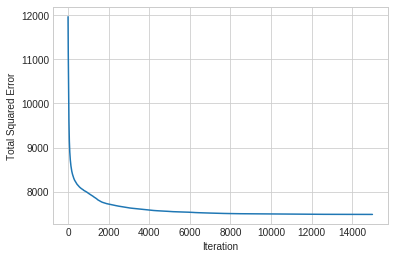

In [41]:
# Plot summed error as a function of iteration
plt.plot(iterations, errors)

plt.xlabel("Iteration")

plt.ylabel("Total Squared Error")

In [42]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_pred_resized = y_pred.resize(11959)


# Make the FloatTensor into a numpy.array
y_pred_array = y_pred_resized.data.numpy()


# Make the numpy.array into a list
y_pred_list = y_pred_array.tolist()


# This is for the validation performance plot later
y_pred_array_for_perf = y_pred_resized.data.numpy()*5.407597 + 7.688844

y_pred_list_for_perf = y_pred_array_for_perf.tolist()

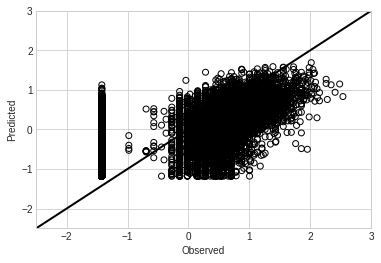

In [43]:
# Plot predictions versus training set outcomes
plt.scatter(outcomes_list, y_pred_list, facecolors = "none", edgecolors = "k")

axes = plt.gca()

axes.set_xlim([-2.5, 3])

axes.set_ylim([-2.5, 3])

plt.plot([-2.5, 3], [-2.5, 3], 'k-', lw = 2)

plt.xlabel("Observed")

plt.ylabel("Predicted")

### Round 3.1: Validation Set Performance

In [44]:
# Get the validation set predictions
y_valid_pred = model(valid_predictors_Variable)


# Get the loss - (total) residual sum of squares
total_SE = loss_fn(y_valid_pred, valid_outcomes_Variable)


# Average that to get mean square error
mean_SE = total_SE / len(y_valid_pred)

mean_SE

Variable containing:
 0.6488
[torch.FloatTensor of size 1]

In [45]:
# Grab the residual sum of squares
resid_sum_squares = loss_fn(y_valid_pred, valid_outcomes_Variable)


# Compute R squared
R_squared = 1 - (resid_sum_squares / tot_sum_squares)

R_squared

Variable containing:
 0.3426
[torch.FloatTensor of size 1]

In [46]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_valid_pred_resized = y_valid_pred.resize(3987)


# Make the FloatTensor into a numpy.array
y_valid_pred_array = y_valid_pred_resized.data.numpy()


# Convert back to log scale
y_valid_pred_array = y_valid_pred_array*5.407597 + 7.688844


# Make the numpy.array into a list
y_valid_pred_list = y_valid_pred_array.tolist()

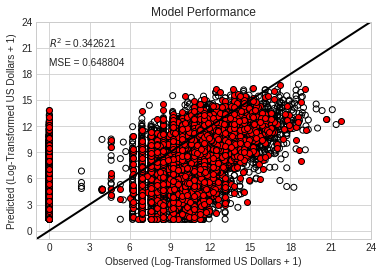

In [47]:
# Plot new predictions versus new data outcomes
plt.scatter(outcomes_list_for_perf, y_pred_list_for_perf, facecolors = "none",
            edgecolors = "k")

plt.scatter(valid_outcomes_list, y_valid_pred_list, facecolors = "r",
            edgecolors = "k")

axes = plt.gca()

axes.set_xlim([-1, 24])

axes.set_ylim([-1, 24])

axes.set_xticks([0, 3, 6, 9, 12, 15, 18, 21, 24])

axes.set_yticks([0, 3, 6, 9, 12, 15, 18, 21, 24])

plt.plot([-1, 24], [-1, 24], 'k-', lw = 2)

axes.set_xlabel("Observed (Log-Transformed US Dollars + 1)")

axes.set_ylabel("Predicted (Log-Transformed US Dollars + 1)")

axes.set_title("Model Performance")

plt.text(0, 21, r"$R^2$ = %s"%(R_squared.data.numpy()[0]))

plt.text(0, 19, "MSE = %s"%(mean_SE.data.numpy()[0]))

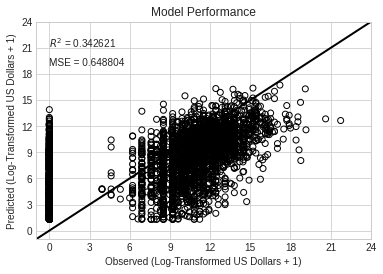

In [48]:
# Plot new predictions versus new data outcomes
plt.scatter(valid_outcomes_list, y_valid_pred_list, facecolors = "none",
            edgecolors = "k")

axes = plt.gca()

axes.set_xlim([-1, 24])

axes.set_ylim([-1, 24])

axes.set_xticks([0, 3, 6, 9, 12, 15, 18, 21, 24])

axes.set_yticks([0, 3, 6, 9, 12, 15, 18, 21, 24])

plt.plot([-1, 24], [-1, 24], 'k-', lw = 2)

axes.set_xlabel("Observed (Log-Transformed US Dollars + 1)")

axes.set_ylabel("Predicted (Log-Transformed US Dollars + 1)")

axes.set_title("Model Performance")

plt.text(0, 21, r"$R^2$ = %s"%(R_squared.data.numpy()[0]))

plt.text(0, 19, "MSE = %s"%(mean_SE.data.numpy()[0]))

In [49]:
model[(0)].weight

Parameter containing:
-0.1295 -0.0791 -0.0891  0.0881  0.4377  0.1541  0.0240 -0.0774 -0.7763
-0.0493  0.1533 -0.5632 -0.1765  0.6393 -0.4196 -0.1124 -0.0496 -0.4583
-0.3093 -0.0192  0.3412  0.1083  1.4357 -0.5516  0.1287 -0.1252  0.0171
 0.0231  0.0096  0.0655  0.4456  0.0455 -0.1180  0.7950  0.3398 -0.3337
-0.0931  0.4543  0.2862 -0.5525  0.5318  0.1085 -0.1033  0.0418  0.0389
-0.0598  0.0058  0.0822  0.0568  0.0846  0.0618  1.3650  0.2259 -0.1089
[torch.FloatTensor of size 6x9]

## Round 4: Four-Hidden-Layer Neural Network

In [50]:
# Make the torch Tensor into a PyTorch Variable for dependent variables
outcomes_Variable = Variable(outcomes_Tensor)


# ...for independent variables
features_Variable = Variable(features_Tensor,
                             requires_grad = False)

In [51]:
# Make the neural network
model = torch.nn.Sequential(torch.nn.Linear(9, 6),
                            torch.nn.ReLU(),
                            torch.nn.Linear(6, 4),
                            torch.nn.ReLU(),
                            torch.nn.Linear(4, 3),
                            torch.nn.ReLU(),
                            torch.nn.Linear(3, 2),
                            torch.nn.ReLU(),
                            torch.nn.Linear(2, 1))

In [52]:
# To add errors to
errors = []


# Set the learning rate
learning_rate = 1e-2


# Define the model's optimizer
optimizer = torch.optim.Adagrad(model.parameters(), lr = learning_rate)


# Train the neural network
for t in range(15000):
    
    # Get the current predictions
    y_pred = model(features_Variable)
    
    # Compute and append current summed errors
    loss = loss_fn(y_pred, outcomes_Variable)
    errors.append(loss.data[0])
    
    # Zero the gradients before running the backward pass.
    optimizer.zero_grad()
    
    # Backward pass: compute gradient of the loss with respect to all the learnable Variables
    loss.backward()
    
    # Update the weights using Adagrad
    optimizer.step()

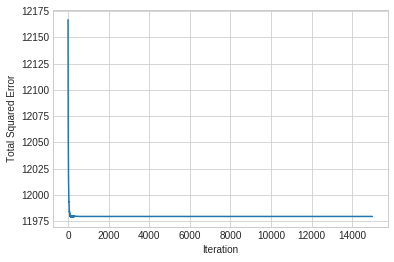

In [53]:
# Plot summed error as a function of iteration
plt.plot(iterations, errors)

plt.xlabel("Iteration")

plt.ylabel("Total Squared Error")

In [54]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_pred_resized = y_pred.resize(11959)


# Make the FloatTensor into a numpy.array
y_pred_array = y_pred_resized.data.numpy()


# Make the numpy.array into a list
y_pred_list = y_pred_array.tolist()


# This is for the validation performance plot later
y_pred_array_for_perf = y_pred_resized.data.numpy()*5.407597 + 7.688844

y_pred_list_for_perf = y_pred_array_for_perf.tolist()

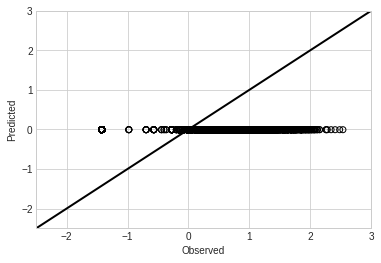

In [55]:
# Plot predictions versus training set outcomes
plt.scatter(outcomes_list, y_pred_list, facecolors = "none", edgecolors = "k")

axes = plt.gca()

axes.set_xlim([-2.5, 3])

axes.set_ylim([-2.5, 3])

plt.plot([-2.5, 3], [-2.5, 3], 'k-', lw = 2)

plt.xlabel("Observed")

plt.ylabel("Predicted")

### Round 4.1: Validation Set Performance

In [56]:
# Get the validation set predictions
y_valid_pred = model(valid_predictors_Variable)


# Get the loss - (total) residual sum of squares
total_SE = loss_fn(y_valid_pred, valid_outcomes_Variable)


# Average that to get mean square error
mean_SE = total_SE / len(y_valid_pred)

mean_SE

Variable containing:
 0.9874
[torch.FloatTensor of size 1]

In [57]:
# Grab the residual sum of squares
resid_sum_squares = loss_fn(y_valid_pred, valid_outcomes_Variable)


# Compute R squared
R_squared = 1 - (resid_sum_squares / tot_sum_squares)

R_squared

Variable containing:
1.00000e-04 *
 -4.6194
[torch.FloatTensor of size 1]

In [58]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_valid_pred_resized = y_valid_pred.resize(3987)


# Make the FloatTensor into a numpy.array
y_valid_pred_array = y_valid_pred_resized.data.numpy()


# Convert back to log scale
y_valid_pred_array = y_valid_pred_array*5.407597 + 7.688844


# Make the numpy.array into a list
y_valid_pred_list = y_valid_pred_array.tolist()

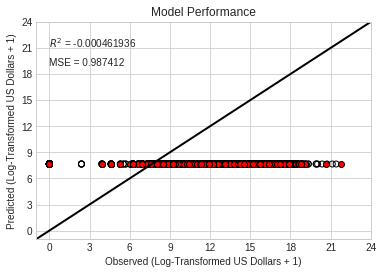

In [59]:
# Plot new predictions versus new data outcomes
plt.scatter(outcomes_list_for_perf, y_pred_list_for_perf, facecolors = "none",
            edgecolors = "k")

plt.scatter(valid_outcomes_list, y_valid_pred_list, facecolors = "r",
            edgecolors = "k")

axes = plt.gca()

axes.set_xlim([-1, 24])

axes.set_ylim([-1, 24])

axes.set_xticks([0, 3, 6, 9, 12, 15, 18, 21, 24])

axes.set_yticks([0, 3, 6, 9, 12, 15, 18, 21, 24])

plt.plot([-1, 24], [-1, 24], 'k-', lw = 2)

axes.set_xlabel("Observed (Log-Transformed US Dollars + 1)")

axes.set_ylabel("Predicted (Log-Transformed US Dollars + 1)")

axes.set_title("Model Performance")

plt.text(0, 21, r"$R^2$ = %s"%(R_squared.data.numpy()[0]))

plt.text(0, 19, "MSE = %s"%(mean_SE.data.numpy()[0]))

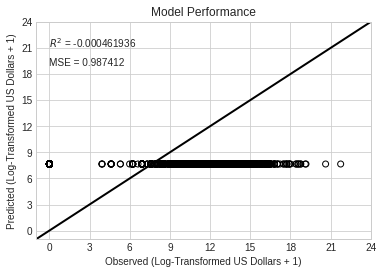

In [60]:
# Plot new predictions versus new data outcomes
plt.scatter(valid_outcomes_list, y_valid_pred_list, facecolors = "none",
            edgecolors = "k")

axes = plt.gca()

axes.set_xlim([-1, 24])

axes.set_ylim([-1, 24])

axes.set_xticks([0, 3, 6, 9, 12, 15, 18, 21, 24])

axes.set_yticks([0, 3, 6, 9, 12, 15, 18, 21, 24])

plt.plot([-1, 24], [-1, 24], 'k-', lw = 2)

axes.set_xlabel("Observed (Log-Transformed US Dollars + 1)")

axes.set_ylabel("Predicted (Log-Transformed US Dollars + 1)")

axes.set_title("Model Performance")

plt.text(0, 21, r"$R^2$ = %s"%(R_squared.data.numpy()[0]))

plt.text(0, 19, "MSE = %s"%(mean_SE.data.numpy()[0]))

In [61]:
model[(0)].weight

Parameter containing:
-0.0378  0.0355 -0.0213  0.2674  0.2593 -0.1131 -0.2558  0.0128 -0.0106
 0.2815 -0.0329  0.1121 -0.1592 -0.2391  0.0642 -0.1989 -0.1107 -0.0756
 0.2327 -0.1437 -0.3093  0.1490 -0.2850 -0.1432 -0.3296 -0.2304 -0.0098
 0.3048  0.1396 -0.2975 -0.1182 -0.0893  0.0920 -0.0534 -0.3053 -0.2159
 0.0196 -0.2243  0.2553 -0.1674 -0.2125 -0.1626 -0.2321 -0.1484  0.2424
-0.0055 -0.0407  0.0321 -0.0835 -0.2674  0.2374 -0.2266 -0.0471  0.2172
[torch.FloatTensor of size 6x9]

## Round 5: Linear Regression

In [62]:
# Make the torch Tensor into a PyTorch Variable for dependent variables
outcomes_Variable = Variable(outcomes_Tensor)


# ...for independent variables
features_Variable = Variable(features_Tensor,
                             requires_grad = False)

In [63]:
# Make the neural network - really a regression
model = torch.nn.Sequential(torch.nn.Linear(9, 1))

In [64]:
# To add errors to
errors = []


# Set the learning rate
learning_rate = 1e-2


# Define the model's optimizer
optimizer = torch.optim.Adagrad(model.parameters(), lr = learning_rate)


# Train the neural network
for t in range(15000):
    
    # Get the current predictions
    y_pred = model(features_Variable)
    
    # Compute and append current summed errors
    loss = loss_fn(y_pred, outcomes_Variable)
    errors.append(loss.data[0])
    
    # Zero the gradients before running the backward pass.
    optimizer.zero_grad()
    
    # Backward pass: compute gradient of the loss with respect to all the learnable Variables
    loss.backward()
    
    # Update the weights using Adagrad
    optimizer.step()

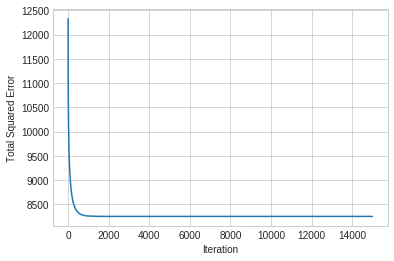

In [65]:
# Plot summed error as a function of iteration
plt.plot(iterations, errors)

plt.xlabel("Iteration")

plt.ylabel("Total Squared Error")

In [66]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_pred_resized = y_pred.resize(11959)


# Make the FloatTensor into a numpy.array
y_pred_array = y_pred_resized.data.numpy()


# Make the numpy.array into a list
y_pred_list = y_pred_array.tolist()


# This is for the validation performance plot later
y_pred_array_for_perf = y_pred_resized.data.numpy()*5.407597 + 7.688844

y_pred_list_for_perf = y_pred_array_for_perf.tolist()

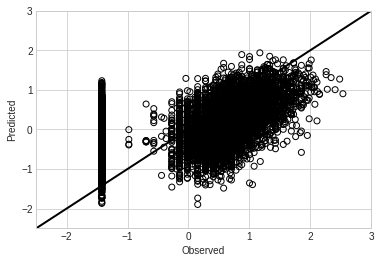

In [67]:
# Plot predictions versus training set outcomes
plt.scatter(outcomes_list, y_pred_list, facecolors = "none", edgecolors = "k")

axes = plt.gca()

axes.set_xlim([-2.5, 3])

axes.set_ylim([-2.5, 3])

plt.plot([-2.5, 3], [-2.5, 3], 'k-', lw = 2)

plt.xlabel("Observed")

plt.ylabel("Predicted")

### Round 5.1: Validation Set Performance

In [68]:
# Get the validation set predictions
y_valid_pred = model(valid_predictors_Variable)


# Get the loss - (total) residual sum of squares
total_SE = loss_fn(y_valid_pred, valid_outcomes_Variable)


# Average that to get mean square error
mean_SE = total_SE / len(y_valid_pred)

mean_SE

Variable containing:
 0.7065
[torch.FloatTensor of size 1]

In [69]:
# Grab the residual sum of squares
resid_sum_squares = loss_fn(y_valid_pred, valid_outcomes_Variable)


# Compute R squared
R_squared = 1 - (resid_sum_squares / tot_sum_squares)

R_squared

Variable containing:
 0.2842
[torch.FloatTensor of size 1]

In [70]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_valid_pred_resized = y_valid_pred.resize(3987)


# Make the FloatTensor into a numpy.array
y_valid_pred_array = y_valid_pred_resized.data.numpy()


# Convert back to log scale
y_valid_pred_array = y_valid_pred_array*5.407597 + 7.688844


# Make the numpy.array into a list
y_valid_pred_list = y_valid_pred_array.tolist()

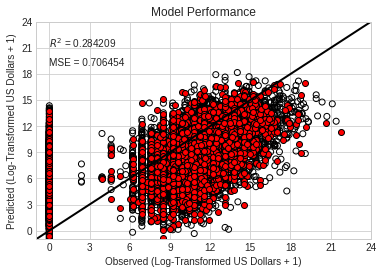

In [71]:
# Plot new predictions versus new data outcomes
plt.scatter(outcomes_list_for_perf, y_pred_list_for_perf, facecolors = "none",
            edgecolors = "k")

plt.scatter(valid_outcomes_list, y_valid_pred_list, facecolors = "r",
            edgecolors = "k")

axes = plt.gca()

axes.set_xlim([-1, 24])

axes.set_ylim([-1, 24])

axes.set_xticks([0, 3, 6, 9, 12, 15, 18, 21, 24])

axes.set_yticks([0, 3, 6, 9, 12, 15, 18, 21, 24])

plt.plot([-1, 24], [-1, 24], 'k-', lw = 2)

axes.set_xlabel("Observed (Log-Transformed US Dollars + 1)")

axes.set_ylabel("Predicted (Log-Transformed US Dollars + 1)")

axes.set_title("Model Performance")

plt.text(0, 21, r"$R^2$ = %s"%(R_squared.data.numpy()[0]))

plt.text(0, 19, "MSE = %s"%(mean_SE.data.numpy()[0]))

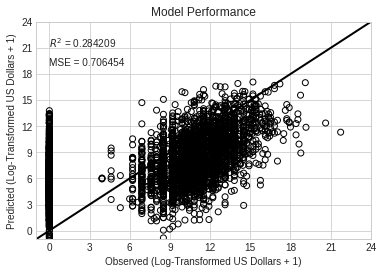

In [72]:
# Plot new predictions versus new data outcomes
plt.scatter(valid_outcomes_list, y_valid_pred_list, facecolors = "none",
            edgecolors = "k")

axes = plt.gca()

axes.set_xlim([-1, 24])

axes.set_ylim([-1, 24])

axes.set_xticks([0, 3, 6, 9, 12, 15, 18, 21, 24])

axes.set_yticks([0, 3, 6, 9, 12, 15, 18, 21, 24])

plt.plot([-1, 24], [-1, 24], 'k-', lw = 2)

axes.set_xlabel("Observed (Log-Transformed US Dollars + 1)")

axes.set_ylabel("Predicted (Log-Transformed US Dollars + 1)")

axes.set_title("Model Performance")

plt.text(0, 21, r"$R^2$ = %s"%(R_squared.data.numpy()[0]))

plt.text(0, 19, "MSE = %s"%(mean_SE.data.numpy()[0]))

In [73]:
model[(0)].weight

Parameter containing:
 0.0110  0.1220  0.1672 -0.2536 -0.2253  0.2483 -0.1553  0.1426  0.0346
[torch.FloatTensor of size 1x9]